In [6]:
import sys
sys.path.append('..')

In [7]:
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn.functional as F

from dsets import ClinicalAgeGroupDataset

In [8]:
model = AutoModelForCausalLM.from_pretrained("microsoft/BioGPT-Large-PubMedQA")
tokenizer = AutoTokenizer.from_pretrained("microsoft/BioGPT-Large-PubMedQA")

In [9]:
dataset = ClinicalAgeGroupDataset('../data')
opposite_age_group = {
    'infant': 'elderly',
    'children': 'adults',
    'adult': 'children',
    'elderly': 'infant',
    'neonate': 'adults',
    'adolescent': 'adults',
    'newborn': 'adults',
}

Loaded dataset with 93 samples


In [5]:
def get_answer_prob(prompt, answer):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    # Forward pass to get the logits
    with torch.no_grad():
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

    # Extract logits at the last position (where answer starts)
    logits = outputs.logits[0, -1, :]  # Shape: [vocab_size]

    # Get token IDs for "Yes", "No", and "Maybe"
    yes_token_id = tokenizer(" Yes", add_special_tokens=False)["input_ids"][0]
    no_token_id = tokenizer(" No", add_special_tokens=False)["input_ids"][0]
    maybe_token_id = tokenizer(" Maybe", add_special_tokens=False)["input_ids"][0]

    # Extract logits for the specific tokens
    answer_logits = logits[[yes_token_id, no_token_id, maybe_token_id]]
    answer_labels = ["Yes", "No", "Maybe"]

    # Convert logits to probabilities
    answer_probs = F.softmax(answer_logits, dim=0)

    if answer == 'yes':
        return answer_probs[0].item()
    elif answer == 'no':
        return answer_probs[1].item()
    elif answer == 'maybe':
        return answer_probs[2].item()
    

In [17]:
prob_diffs = []
for i in range(len(dataset)):
    data = dataset[i]
    age_replacement = opposite_age_group[data['age_group']]
    corrupted_question = data['question'].replace(data['age_group'], age_replacement)
    corrupted_context = data['context'].replace(data['age_group'], age_replacement)

    original_prompt = f"Question: {data['question']} Context: {data['context']} the answer to the question given the context is"
    corrupted_prompt = f"Question: {corrupted_question} Context: {corrupted_context} the answer to the question given the context is"

    original_prob = get_answer_prob(original_prompt, data['answer'])
    corrupted_prob = get_answer_prob(corrupted_prompt, data['answer'])

    prob_diffs.append(original_prob - corrupted_prob)

In [15]:
def plot_histogram(data, title):
    plt.hist(data, bins=20)
    plt.title(title)
    plt.xlabel('Answer Token Probability Difference')
    plt.ylabel('Frequency')
    plt.show()

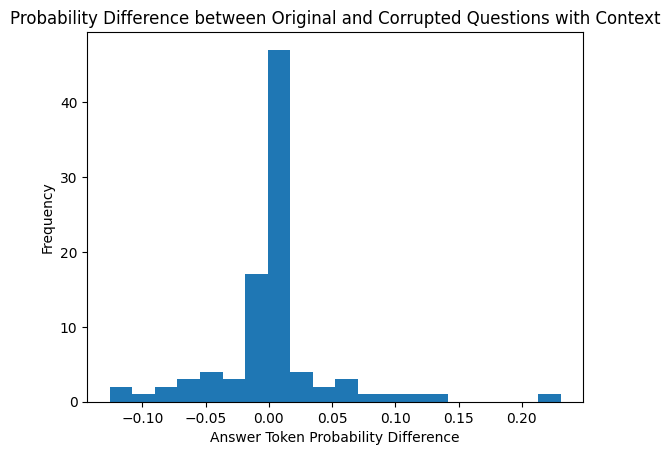

In [18]:
plot_histogram(prob_diffs, 'Probability Difference between Original and Corrupted Questions with Context')